In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV   #Perforing grid search
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import svm
import tensorflow as tf

# 데이터로드

In [2]:
data = pd.read_csv('data_no8.csv')
data_x = pd.read_csv('data_x.csv')
data_y = pd.read_csv('data_y.csv')

data_x_dnn = np.load('data_x_norm.npy')
data_y_dnn = np.loadtxt('data_y.csv', skiprows=1, delimiter=',')
data_y_dnn = np.array(data_y_dnn).reshape(-1,1)


### 트레인 테스트셋 나누기

In [3]:
#for dnn
X_train_dnn, X_test_dnn, y_train_dnn, y_test_dnn = train_test_split(data_x_dnn, data_y_dnn, test_size=0.2,random_state = 42)
#for the others
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y,test_size=0.2, random_state = 42)

In [25]:
# X_train, X_test, y_train, y_test = train_test_split(data, data['DE1_dg'],test_size=0.2, random_state = 42)
# X_train = X_train.iloc[:, ~X_train.columns.isin(['DE1_dg'])]
# X_test = X_test.iloc[:, ~X_test.columns.isin(['DE1_dg'])]

In [4]:
X_train_dnn

array([[-0.25460342, -0.47701003, -1.07009819, ..., -0.33052995,
         1.81635821,  1.29455465],
       [ 0.16594132,  2.09639197, -1.07009819, ..., -0.15436423,
         0.84346473, -0.23941732],
       [ 0.37621369, -0.47701003,  0.93449369, ..., -0.27180804,
        -0.6158755 , -0.23941732],
       ...,
       [-1.30596528, -0.47701003, -1.07009819, ..., -0.33052995,
        -0.6158755 , -0.23941732],
       [ 0.58648607, -0.47701003, -1.07009819, ..., -0.21308613,
        -0.6158755 ,  1.29455465],
       [ 1.00703081,  2.09639197, -1.07009819, ..., -0.27180804,
        -0.6158755 ,  1.29455465]])

In [11]:
np.array(X_train)

array([[-0.25460342, -0.47701003, -1.07009819, ..., -0.33052995,
         1.81635821,  1.29455465],
       [ 0.16594132,  2.09639197, -1.07009819, ..., -0.15436423,
         0.84346473, -0.23941732],
       [ 0.37621369, -0.47701003,  0.93449369, ..., -0.27180804,
        -0.6158755 , -0.23941732],
       ...,
       [-1.30596528, -0.47701003, -1.07009819, ..., -0.33052995,
        -0.6158755 , -0.23941732],
       [ 0.58648607, -0.47701003, -1.07009819, ..., -0.21308613,
        -0.6158755 ,  1.29455465],
       [ 1.00703081,  2.09639197, -1.07009819, ..., -0.27180804,
        -0.6158755 ,  1.29455465]])

# DNN

In [5]:
X = tf.placeholder(tf.float32, shape=(None, 321))
Y = tf.placeholder(tf.float32, shape=(None,1))
training = tf.placeholder(tf.bool)

In [6]:
#layers
L = 6
# units
units=[X.shape[1] ,256,128,64,32,16,8,1]   

W1 = tf.get_variable('W1',shape=[units[0],units[1]], initializer= tf.contrib.layers.variance_scaling_initializer())
B1 = tf.Variable(tf.random_normal([units[1]]))
Z1 = tf.matmul(X,W1)+B1
Z1 = tf.layers.batch_normalization(Z1)
A1 = tf.nn.relu(Z1)
dropout1 = tf.layers.dropout(A1, rate=0.7, training=training)

W2 = tf.get_variable('W2',shape=[ units[1],units[2]], initializer= tf.contrib.layers.variance_scaling_initializer())
B2 = tf.Variable(tf.random_normal([units[2]]))
Z2 = tf.matmul(A1,W2)+B2
Z2 = tf.layers.batch_normalization(Z2)
A2 = tf.nn.relu(Z2)
dropout2 = tf.layers.dropout(A2, rate=0.7, training=training)

W3 = tf.get_variable('W3',shape=[ units[2],units[3]], initializer= tf.contrib.layers.variance_scaling_initializer())
B3 = tf.Variable(tf.random_normal([units[3]]))
Z3 = tf.matmul(A2,W3)+B3
Z3 = tf.layers.batch_normalization(Z3)
A3 = tf.nn.relu(Z3)
dropout3 = tf.layers.dropout(A3, rate=0.7, training=training)

W4 = tf.get_variable('W4',shape=[ units[3],units[4]], initializer= tf.contrib.layers.variance_scaling_initializer())
B4 = tf.Variable(tf.random_normal([units[4]]))
Z4 = tf.matmul(A3,W4)+B4
Z4 = tf.layers.batch_normalization(Z4)
A4 = tf.nn.relu(Z4)
dropout4 = tf.layers.dropout(A4, rate=0.7, training=training)

W5 = tf.get_variable('W5', shape = [units[4], units[5]], initializer = tf.contrib.layers.variance_scaling_initializer())
B5 = tf.Variable(tf.random_normal([units[5]]))
Z5 = tf.matmul(A4,W5)+B5
Z5 = tf.layers.batch_normalization(Z5)
A5 = tf.nn.relu(Z5)
dropout5 = tf.layers.dropout(A5, rate=0.7, training=training)

W6 = tf.get_variable('W6', shape = [units[5], units[6]], initializer = tf.contrib.layers.variance_scaling_initializer())
B6 = tf.Variable(tf.random_normal([units[6]]))
Z6 = tf.matmul(A5,W6)+B6
Z6 = tf.layers.batch_normalization(Z6)
A6 = tf.nn.sigmoid(Z6)
dropout6 = tf.layers.dropout(A6, rate=0.7, training=training)

W7 = tf.get_variable('W7', shape = [units[6], units[7]], initializer = tf.contrib.layers.variance_scaling_initializer())
B7 = tf.Variable(tf.random_normal([units[7]]))
Z7 = tf.matmul(A6,W7)+B7

cost = tf.reduce_mean(tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels= Y, logits=Z7)))
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)


In [39]:
# sess = tf.Session()
# sess.run(tf.global_variables_initializer())

mini = 64
epoch= 3000
n_mini = epoch//mini
for i in range(epoch):
    for j in range(n_mini):
        c , _ = sess.run([cost, optimizer], 
                         feed_dict={X: X_train_dnn[j * mini : (j+1) * mini], Y: y_train_dnn[j * mini : (j+1) * mini],
                                   training:True})
    c , _ = sess.run([cost, optimizer], 
                         feed_dict={X: X_train_dnn[n_mini * mini :], Y: y_train_dnn[n_mini * mini :],
                                   training:True})    
    if i%200 == 0:
        print('iter : {}, cost : {}'.format(i,c))

iter : 0, cost : 401.302490234375
iter : 200, cost : 401.302490234375
iter : 400, cost : 401.3024597167969
iter : 600, cost : 401.30242919921875
iter : 800, cost : 401.30242919921875
iter : 1000, cost : 401.30242919921875
iter : 1200, cost : 401.30242919921875
iter : 1400, cost : 401.30242919921875
iter : 1600, cost : 401.30242919921875
iter : 1800, cost : 401.30242919921875
iter : 2000, cost : 401.30242919921875
iter : 2200, cost : 401.30242919921875
iter : 2400, cost : 401.30242919921875
iter : 2600, cost : 401.30242919921875
iter : 2800, cost : 401.30242919921875


In [40]:
yhat_test = sess.run(tf.round(tf.nn.sigmoid(Z7)), feed_dict={X:X_test_dnn, training:False})

In [41]:
#f1 score
f1_score(y_test,yhat_test)

0.7437262357414448

In [31]:
dnn_yhat = sess.run(tf.nn.sigmoid(Z7), feed_dict={X:X_test_dnn, training:False})

In [68]:
dnn_prob = np.zeros((dnn_yhat.shape[0],2))

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [69]:
for i in range(len(dnn_yhat)):
    if dnn_yhat[i] < 0.5:
        dnn_prob[i][0] = dnn_yhat[i]
    else:
        dnn_prob[i][1] = dnn_yhat[i] - 0.5

In [70]:
dnn_prob

array([[0.0025641 , 0.        ],
       [0.0025641 , 0.        ],
       [0.        , 0.14181608],
       ...,
       [0.0025641 , 0.        ],
       [0.0025641 , 0.        ],
       [0.0025641 , 0.        ]])

# xgboost

In [34]:
xgb_ = XGBClassifier()
xgb_.fit(X_train, y_train)

c:\users\nb-0242\anaconda3\envs\ximz\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\nb-0242\anaconda3\envs\ximz\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [65]:
xgb_prob = xgb_.predict_proba(X_test)

In [54]:
xgb_yhat = xgb_.predict(X_test)
f1_score(y_test, xgb_yhat)

0.7570332480818415

In [124]:
xgb_imp=pd.Series(xgb_.feature_importances_,index=X_train.columns)

# svm

In [61]:
svm_ =svm.SVC(probability = True ,gamma='scale' ,class_weight={0:3, 1:7})
svm_.fit(X_train,y_train)

c:\users\nb-0242\anaconda3\envs\ximz\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, cache_size=200, class_weight={0: 3, 1: 7}, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [64]:
svm_prob=svm_.predict_proba(X_test)

In [62]:
svm_yhat = svm_.predict(X_test)

In [63]:
f1_score(y_test, svm_yhat)

0.7458952306489446

# rf

In [36]:
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train, y_train)

c:\users\nb-0242\anaconda3\envs\ximz\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\nb-0242\anaconda3\envs\ximz\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [66]:
rf_prob = rf.predict_proba(X_test)

In [123]:
rf_yhat = rf.predict(X_test)
rf_imp = pd.Series(rf.feature_importances_, index=X_test.columns)
f1_score(y_test, rf_yhat)

0.7176258992805755

# ensemble ㅏㅡㅏ!!!

In [114]:
ensemble_prob = 0.2 * dnn_prob + 0.1 * rf_prob + 0.4 * xgb_prob + 0.3 * svm_prob

In [115]:
ensemble_prob

array([[0.71710667, 0.08340617],
       [0.7947106 , 0.00580223],
       [0.62898112, 0.19938208],
       ...,
       [0.75906403, 0.04144878],
       [0.79159122, 0.00892158],
       [0.78646997, 0.01404285]])

In [116]:
yhat = np.argmax(ensemble_prob,axis=1)

In [117]:
yhat

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [118]:
sum(np.equal(yhat.reshape(-1,1), y_test.values))[0]/len(y_test)

0.9435318275154004

In [119]:
f1_score(y_test, yhat)

0.7717842323651453

# feature importances

In [128]:
xgb_imp_50 = xgb_imp.sort_values(ascending=False)[:50]
rf_imp_50 = rf_imp.sort_values(ascending=False)[:50]

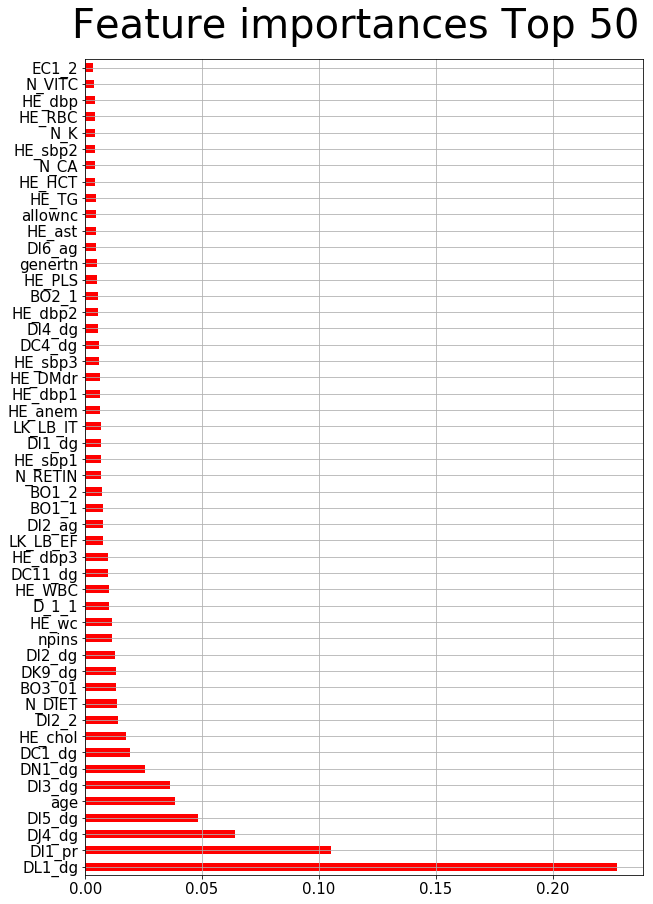

In [155]:
plt.figure(figsize=(10,15))
plt.figtext(.5,.9,'Feature importances Top 50', fontsize=40, ha='center')
xgb_imp_50.plot(kind='barh',grid=True,fontsize=15, colormap='hsv')

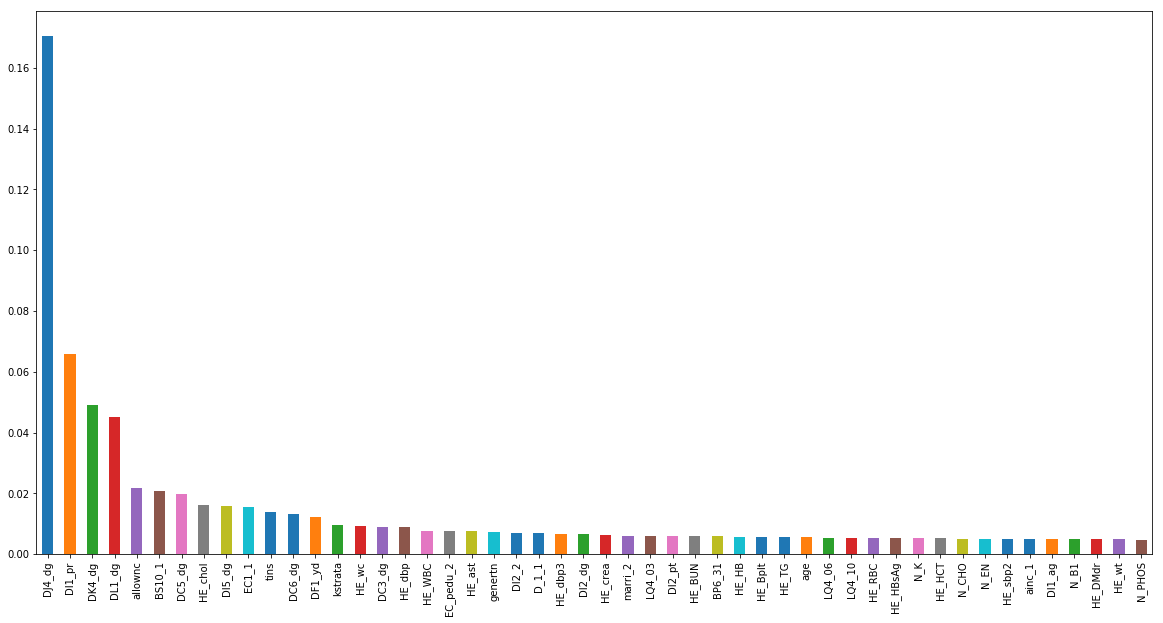

In [132]:
plt.figure(figsize=(20,10))
rf_imp_50.plot(kind='bar')